In [671]:
import matplotlib.pyplot as plt
import numpy as np

In [672]:
mi = 1.3
lambda_ = 0.5

mi_prime = 1.2
lambda_prime = 0.3

size_y = 4
size_x = 20

bounding_box = np.array([0, 5, 0, 1])

In [673]:
def f1(x, y):
    x = np.array(x)
    y = np.array(y)
    result = np.zeros_like(x)
    # cond = (0 <= x) & (x <= 5) & (0 <= y) & (y <= 1)
    cond = np.ones_like(x) == 1
    result[cond] = 0
    return result


def f2(x, y):
    x = np.array(x)
    y = np.array(y)
    result = np.zeros_like(x)
    # cond = (3 <= x) & (x <= 4) & (0 <= y) & (y <= 1)
    cond = np.ones_like(x) == 1
    result[cond] = 0
    return result


def fnx(x, y):
    x = np.array(x)
    y = np.array(y)
    result = np.zeros_like(x)
    if x == 5:
        result = -1
    return result


def fny(x, y):
    x = np.array(x)
    y = np.array(y)
    result = 0
    if x == 5:
        result = 0
    return result


In [674]:
x = np.linspace(bounding_box[0], bounding_box[1], size_x + 1)
y = np.linspace(bounding_box[2], bounding_box[3], size_y + 1)
vertices = np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])

In [675]:
vertices = np.array(sorted(vertices, key=lambda x: x[0]))

In [676]:
dirichlet_boundary = np.where(vertices[:, 0] == bounding_box[0])[0]
neumann_boundary = np.where((vertices[:, 1] == bounding_box[3])
                            | (vertices[:, 0] == bounding_box[1]))[0]

contact_boundary = np.where((vertices[:, 1] == bounding_box[2]))[0]

elements = np.array(
    [np.array([i, i + 1, i + 2 + size_y, i + 1 + size_y]) + (j * (size_y + 1)) for i in range(size_y) for j in
     range(size_x)])
# elements = np.array(
#     [np.array([[i, i + 1, i + 1 + size_y], [i + 1 + size_y, i + 1, i + size_y + 2]]) + (j * (size_y + 1)) for i in range(size_y) for j in range(size_x)]).reshape(-1, 3)

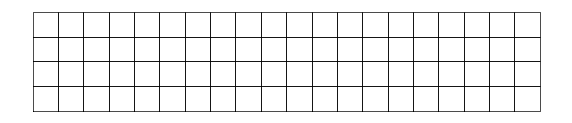

In [677]:
fig = plt.figure(figsize=(10, 2))
for element in elements:
    xx = [vertices[e][0] for e in element]
    xx.append(xx[0])
    yy = [vertices[e][1] for e in element]
    yy.append(yy[0])
    plt.plot(xx, yy, c="black", linewidth=0.7)
plt.axis('off')
plt.show()

In [678]:
def calculate_stiffness_matrix(vertices, elements, mi, lambda_):
    A = np.zeros((len(vertices) * 2, len(vertices) * 2))
    for element in elements:
        local_vertices = vertices[element]
        x = local_vertices[:, 0]
        y = local_vertices[:, 1]
        n_of_sides = len(element)
        range_plus_one = np.array([*range(1, n_of_sides), 0])
        area_part = np.array([x[i] * y[j] - x[j] * y[i] for i, j in zip(range(n_of_sides), range_plus_one)])
        area = 1 / 2 * np.sum(area_part)
        centroid = 1 / (6 * area) * np.sum([(d + d[range_plus_one]) * area_part for d in [x, y]], axis=1)
        B_snake_x = np.zeros((6, n_of_sides))
        B_snake_y = np.zeros((6, n_of_sides))

        B_snake_x[0, :] = 1
        B_snake_x[1, :] = 0
        B_snake_y[0, :] = 0
        B_snake_y[1, :] = 1
        for vertex_id in range(n_of_sides):
            vertex = local_vertices[vertex_id]
            previous_id = vertex_id - 1
            previous = local_vertices[previous_id]
            next_id = (vertex_id + 1) % n_of_sides
            next = local_vertices[next_id]
            vertex_hat_normal = -np.array([next[1] - previous[1], previous[0] - next[0]])
            B_snake_x[2, vertex_id] = -vertex[1]
            B_snake_x[3, vertex_id] = mi * vertex_hat_normal[1]
            B_snake_x[4, vertex_id] = mi * vertex_hat_normal[0]
            B_snake_x[5, vertex_id] = (mi + lambda_) * vertex_hat_normal[0]
            B_snake_y[2, vertex_id] = vertex[0]
            B_snake_y[3, vertex_id] = mi * vertex_hat_normal[0]
            B_snake_y[4, vertex_id] = -mi * vertex_hat_normal[1]
            B_snake_y[5, vertex_id] = (mi + lambda_) * vertex_hat_normal[1]

        D = np.zeros((2 * n_of_sides, 6))
        for i in range(n_of_sides):
            x = local_vertices[i, 0]
            y = local_vertices[i, 1]
            D[i] = np.array([1, 0, -y + centroid[1], y - centroid[1], x - centroid[0], x - centroid[0]])
            D[i + n_of_sides] = np.array([0, 1, x - centroid[0], x - centroid[0], -y + centroid[1], y - centroid[1]])

        B_snake = np.hstack([B_snake_x, B_snake_y])
        G_snake = B_snake @ D

        G = np.zeros((6, 6))
        G[3:, 3:] = G_snake[3:, 3:]

        projector = np.linalg.solve(G_snake, B_snake)
        Al = np.eye(2 * n_of_sides)
        part = Al - D @ projector
        stabilizing_term = part.T @ part

        local_stiffness = projector.T @ G @ projector
        local_stiffness_with_stabilizing_term = local_stiffness + stabilizing_term

        full_element = np.concatenate([element, element + len(vertices)])
        A[np.ix_(full_element, full_element)] += local_stiffness_with_stabilizing_term
    return A


def calculate_F_j(vertices, elements, fx, fy):
    F = np.zeros(len(vertices) * 2)
    j = np.zeros(len(vertices) * 2)

    for element in elements:
        local_vertices = vertices[element]
        x = local_vertices[:, 0]
        y = local_vertices[:, 1]
        n_of_sides = len(element)
        range_plus_one = np.array([*range(1, n_of_sides), 0])
        area_part = np.array([x[i] * y[j] - x[j] * y[i] for i, j in zip(range(n_of_sides), range_plus_one)])
        area = 1 / 2 * np.sum(area_part)
        centroid = 1 / (6 * area) * np.sum([(d + d[range_plus_one]) * area_part for d in [x, y]], axis=1)
        area = np.abs(area)

        for vertex_id in range(n_of_sides):
            vertex = local_vertices[vertex_id]
            previous_id = vertex_id - 1
            previous = local_vertices[previous_id]
            next_id = (vertex_id + 1) % n_of_sides
            next = local_vertices[next_id]

            if np.isin(element[vertex_id], neumann_boundary) and np.isin(element[previous_id], neumann_boundary):
                mean_prev_vertex = (vertex[0] + previous[0]) / 2, (vertex[1] + previous[1]) / 2
                length = np.linalg.norm(vertex - previous)
                F[element[vertex_id]] += (fnx(mean_prev_vertex[0], mean_prev_vertex[1])) * length / 2
                F[element[vertex_id] + len(vertices)] += (fny(mean_prev_vertex[0], mean_prev_vertex[1])) * length / 2

            if np.isin(element[vertex_id], neumann_boundary) and np.isin(element[next_id], neumann_boundary):
                mean_next_vertex = (vertex[0] + next[0]) / 2, (vertex[1] + next[1]) / 2
                length = np.linalg.norm(vertex - next)
                F[element[vertex_id]] += (fnx(mean_next_vertex[0], mean_next_vertex[1])) * length / 2
                F[element[vertex_id] + len(vertices)] += (fny(mean_next_vertex[0], mean_next_vertex[1])) * length / 2

            if np.isin(element[vertex_id], contact_boundary) and np.isin(element[previous_id], contact_boundary):
                length = np.linalg.norm(vertex - previous)
                j[element[vertex_id]] += length / 2

            if np.isin(element[vertex_id], contact_boundary) and np.isin(element[next_id], contact_boundary):
                length = np.linalg.norm(vertex - next)
                j[element[vertex_id]] += length / 2

        F[element] += fx(centroid[0], centroid[1]) * area / n_of_sides
        F[element + len(vertices)] += fy(centroid[0], centroid[1]) * area / n_of_sides

    return F, j

In [679]:
internal_vertices = np.tile(~np.isin(np.arange(len(vertices)), dirichlet_boundary), 2)
internal_vertices[len(vertices):] = internal_vertices[len(vertices):] & (
    ~np.isin(np.arange(len(vertices)), contact_boundary))
internal_vertices = np.where(internal_vertices)[0]

In [680]:
A = calculate_stiffness_matrix(vertices, elements, mi, lambda_)
B = calculate_stiffness_matrix(vertices, elements, mi_prime, lambda_prime)
F, j = calculate_F_j(vertices, elements, f1, f2)

In [681]:
u = np.zeros(len(vertices) * 2)
dt = 0.05
ut = [np.zeros_like(u)]

In [682]:
Ai = A[np.ix_(internal_vertices, internal_vertices)]
Bi = B[np.ix_(internal_vertices, internal_vertices)]
Fi = F[internal_vertices]
contact_internal_boundary = np.intersect1d(internal_vertices, contact_boundary)
non_contact_internal_boundary = np.setdiff1d(internal_vertices, contact_internal_boundary)
At = A * dt + B
Ati = At[np.ix_(internal_vertices, internal_vertices)]
Acc = At[np.ix_(contact_internal_boundary, contact_internal_boundary)]
Acn = At[np.ix_(contact_internal_boundary, non_contact_internal_boundary)]
Anc = At[np.ix_(non_contact_internal_boundary, contact_internal_boundary)]
Ann = At[np.ix_(non_contact_internal_boundary, non_contact_internal_boundary)]

A_snake = Acc - Acn @ np.linalg.solve(Ann, Anc)

Ann_v2 = np.zeros_like(A)
Ann_v2[np.ix_(non_contact_internal_boundary, non_contact_internal_boundary)] = Ann
Ann_v2[np.ix_(contact_internal_boundary, contact_internal_boundary)] = np.eye(len(contact_internal_boundary))
Ann_v2 = Ann_v2[np.ix_(internal_vertices, internal_vertices)]

Fc = F[contact_internal_boundary]
Fn = F[non_contact_internal_boundary]
F_snake = Fc - Acn @ np.linalg.solve(Ann, Fn)


Fn_v2 = np.zeros_like(F)
Fn_v2[non_contact_internal_boundary] = Fn
Fn_v2 = Fn_v2[internal_vertices]

Anc_v2 = np.zeros((A.shape[0], len(contact_internal_boundary)))
Anc_v2[contact_internal_boundary, :] = -np.eye(len(contact_internal_boundary))
Anc_v2[non_contact_internal_boundary, :] = Anc
Anc_v2 = Anc_v2[internal_vertices]

In [709]:
import autograd.numpy as np
from autograd import grad

a = 1


def subdiff_function(v_tau):
    return np.exp(-np.abs(v_tau)) * (a - 1) + np.abs(v_tau) * a


def integral(v):
    result = 0.2 * np.sum(subdiff_function(v) * j[contact_internal_boundary])
    return result


def Jt_snake(u_prime, u_old_full):
    return 1/2 * (u_prime @ A_snake @ u_prime) - F_snake @ u_prime + integral(u_prime) + u_old_full @ Ai @ np.linalg.solve(Ann_v2, Fn_v2 - Anc_v2 @ u_prime)


def J_snake(u_prime, u_old_full):
    return 1/2 * (u_prime[internal_vertices] @ Ati @ u_prime[internal_vertices]) - Fi @ u_prime[internal_vertices] + integral(u_prime[contact_internal_boundary]) + u_old_full @ Ai @ u_prime[internal_vertices]


J_snake_jac = grad(J_snake)
Jt_snake_jac = grad(Jt_snake)

In [703]:
for v in np.random.normal(size=(12,len(contact_internal_boundary))):
    old = np.zeros((len(internal_vertices),))
    w = np.zeros_like(u)
    w[contact_internal_boundary] = v
    w[non_contact_internal_boundary] = np.linalg.solve(Ann, Fn - Anc @ v)
    print(Jt_snake(v,old))
    print(J_snake(w, old))
    # print(1 / 2 * v @ (Acc - Acn @ np.linalg.solve(Ann, Anc)) @ v)
    # print(1 / 2 * w[internal_vertices] @ Ati @ w[internal_vertices])
    # print(F_snake @ v)
    # print(Fi @ w[internal_vertices])

25.765498432668874
25.59971618785885
25.472368515830443
25.306586271020404
15.428534106917374
15.262751862107342
19.199540928274555
19.033758683464526
20.730809263048595
20.56502701823857
20.347559984385416
20.181777739575384
16.176673669250043
16.010891424440015
17.76325239192385
17.597470147113825
17.80785603234055
17.64207378753052
9.470483145405929
9.304700900595897
20.85638850140156
20.69060625659153
38.53852330992957
38.372741065119556


In [714]:
import scipy.optimize
from autograd import grad

ut = [np.zeros_like(u)]
for _ in range(50):
    u_old_full = ut[-1][internal_vertices]
    F_temp = F.copy()
    F_temp[internal_vertices] = Fi - u_old_full @ Ai
    Fc = F_temp[contact_internal_boundary]
    Fn = F_temp[non_contact_internal_boundary]
    F_snake = Fc - Acn @ np.linalg.solve(Ann, Fn)

    def Jt_snake(u_prime):
        return 1/2 * (u_prime @ A_snake @ u_prime) - F_snake @ u_prime + integral(u_prime)

    Jt_snake_jac = grad(Jt_snake)

    res = scipy.optimize.minimize(Jt_snake, ut[-1][contact_internal_boundary], jac=Jt_snake_jac, method='BFGS', options={"disp": True})

    ds = np.zeros_like(u)
    ds[contact_internal_boundary] = res.x * dt
    ds[non_contact_internal_boundary] = np.linalg.solve(Ann, Fn - Anc @ res.x) * dt
    print(J_snake(ds,ut[-1][internal_vertices]))
    ut.append(ut[-1] + ds)


lol
         Current function value: -0.155417
         Iterations: 29
         Function evaluations: 109
         Gradient evaluations: 103
-0.03131082188224048
lol
         Current function value: -0.139191
         Iterations: 72
         Function evaluations: 177
         Gradient evaluations: 171
-0.028062260012062964
lol
         Current function value: -0.124629
         Iterations: 55
         Function evaluations: 134
         Gradient evaluations: 128
-0.025142686911369096
lol
         Current function value: -0.111592
         Iterations: 57
         Function evaluations: 117
         Gradient evaluations: 111
-0.022527876825070986
lol
         Current function value: -0.099915
         Iterations: 34
         Function evaluations: 106
         Gradient evaluations: 102
-0.020184466902048254
lol
         Current function value: -0.089308
         Iterations: 56
         Function evaluations: 133
         Gradient evaluations: 127
-0.01807520164416098
lol
         Current fun

In [711]:

ut = [np.zeros_like(u)]
for _ in range(50):
    res = scipy.optimize.minimize(J_snake, ut[-1], jac=J_snake_jac, method='BFGS',
                                  args=ut[-1][internal_vertices], options={"disp": True})
    ds = np.zeros_like(u)
    ds[internal_vertices] = res.x[internal_vertices] * dt
    ut.append(ut[-1] + ds)

lol
         Current function value: -0.321229
         Iterations: 88
         Function evaluations: 154
         Gradient evaluations: 148
lol
         Current function value: -0.287797
         Iterations: 95
         Function evaluations: 159
         Gradient evaluations: 154
lol
         Current function value: -0.257867
         Iterations: 117
         Function evaluations: 191
         Gradient evaluations: 185
lol
         Current function value: -0.231043
         Iterations: 119
         Function evaluations: 196
         Gradient evaluations: 192
lol
         Current function value: -0.207021
         Iterations: 106
         Function evaluations: 155
         Gradient evaluations: 149
lol
         Current function value: -0.185508
         Iterations: 156
         Function evaluations: 243
         Gradient evaluations: 238
lol
         Current function value: -0.166225
         Iterations: 119
         Function evaluations: 192
         Gradient evaluations: 188
lol
    

In [715]:
u = ut[-1]

C:\ProgramData\Miniconda3\envs\nrrrc\lib\site-packages\scipy\interpolate\_fitpack_impl.py:976: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=18,9 m=105 fp=0.000008 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
C:\ProgramData\Miniconda3\envs\nrrrc\lib\site-packages\scipy\interpolate\_fitpack_impl.py:976: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=18,9 m=105 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


<BarContainer object of 21 artists>

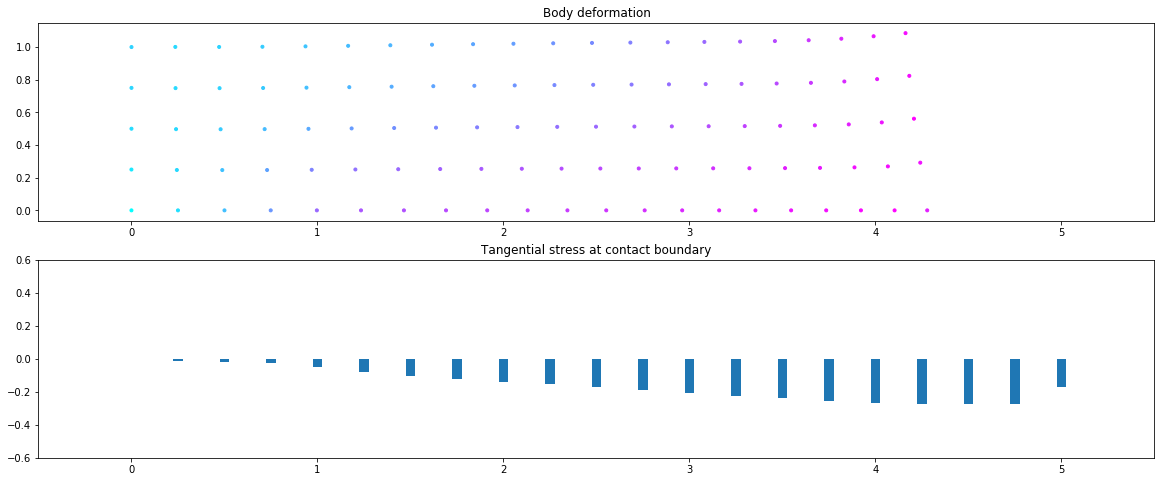

In [716]:
import scipy.interpolate

fig, axs = plt.subplots(2, figsize=(20, 8))
dx = 0.25
dy = 0.25
x = vertices[:, 0].copy()
y = vertices[:, 1].copy()
u_x = u[:len(vertices)].copy()
u_y = u[len(vertices):].copy()
u_fun_x = scipy.interpolate.interp2d(x, y, u_x, kind='linear')
u_fun_y = scipy.interpolate.interp2d(x, y, u_y, kind='linear')
xi, yi = np.arange(0, 5 + dx, dx), np.arange(0, 1 + dy, dy)
u_xi = u_fun_x(xi, yi)
u_yi = u_fun_y(xi, yi)
grad = np.array([np.gradient(u_xi, dx, dy), np.gradient(u_yi, dx, dy)]).reshape((2, 2, -1))
epsilon = (grad + np.transpose(grad, axes=(1, 0, 2))) / 2
stress = lambda_ * np.trace(epsilon) * np.repeat(np.eye(2)[:, :, np.newaxis], grad.shape[2], axis=2) + 2 * mi * epsilon
c = np.linalg.norm(stress, axis=(0, 1))
xxi, yyi = np.meshgrid(xi, yi)
xxi += u_xi
yyi += u_yi
axs[0].set_title("Body deformation")
axs[0].set_xlim(-0.5, 5.5)
axs[0].scatter(xxi, yyi, marker='.', cmap='cool', c=c.reshape(*xxi.shape))
axs[1].set_title("Tangential stress at contact boundary")
axs[1].set_xlim(-0.5, 5.5)
axs[1].set_ylim(-0.6, 0.6)
axs[1].bar(np.linspace(0, 5, len(stress[1, 0, vertices[:, 1] == 0])), stress.reshape(2, 2, *xxi.shape)[1, 0, 0],
           width=0.05)

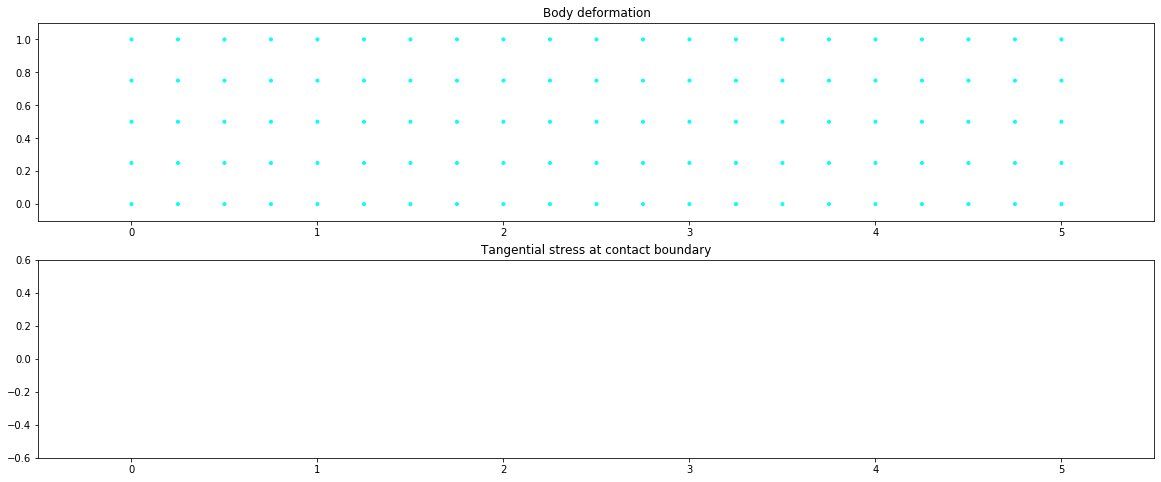

In [717]:
from matplotlib.animation import FuncAnimation

fig, axs = plt.subplots(2, figsize=(20, 8))


def animation(i):
    axs[0].clear()
    axs[1].clear()
    dx = 0.25
    dy = 0.25
    x = vertices[:, 0].copy()
    y = vertices[:, 1].copy()
    u_x = ut[i][:len(vertices)].copy()
    u_y = ut[i][len(vertices):].copy()
    u_fun_x = scipy.interpolate.interp2d(x, y, u_x, kind='linear')
    u_fun_y = scipy.interpolate.interp2d(x, y, u_y, kind='linear')
    xi, yi = np.arange(0, 5 + dx, dx), np.arange(0, 1 + dy, dy)
    u_xi = u_fun_x(xi, yi)
    u_yi = u_fun_y(xi, yi)
    grad = np.array([np.gradient(u_xi, dx, dy), np.gradient(u_yi, dx, dy)]).reshape(2, 2, -1)
    epsilon = (grad + np.transpose(grad, axes=(1, 0, 2))) / 2
    stress = lambda_ * np.trace(epsilon) * np.repeat(np.eye(2)[:, :, np.newaxis], grad.shape[2],
                                                     axis=2) + 2 * mi * epsilon
    c = np.linalg.norm(stress, axis=(0, 1))
    xxi, yyi = np.meshgrid(xi, yi)
    xxi += u_xi
    yyi += u_yi
    axs[0].set_title("Body deformation")
    axs[0].set_xlim(-0.5, 5.5)
    axs[0].set_ylim(-0.1, 1.1)
    axs[0].scatter(xxi, yyi, marker='.', cmap='cool', c=c.reshape(*xxi.shape))
    axs[1].set_title("Tangential stress at contact boundary")
    axs[1].set_xlim(-0.5, 5.5)
    axs[1].set_ylim(-0.6, 0.6)
    axs[1].bar(np.linspace(0, 5, xxi.shape[1]), stress.reshape(2, 2, *xxi.shape)[1, 0, 0], width=0.05)


ani = FuncAnimation(fig, animation, frames=50, interval=50, repeat=False)

animation(0)

In [718]:
from matplotlib.animation import ImageMagickWriter

ani.save('animationSchur.gif', writer=ImageMagickWriter(fps=10))

C:\ProgramData\Miniconda3\envs\nrrrc\lib\site-packages\scipy\interpolate\_fitpack_impl.py:976: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=18,9 m=105 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
C:\ProgramData\Miniconda3\envs\nrrrc\lib\site-packages\scipy\interpolate\_fitpack_impl.py:976: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=16,10 m=105 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
C:\ProgramData\Miniconda3\envs\nrrrc\lib\site-packages\scipy\interpolate\_fitpack_impl.py:976: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m